## This notebook will work on trying to get RADIAN working with MultiPolygons

In [2]:
# Package imports
import random
from random import randint
import time

import os
import json
import string
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import contextily as cx
import warnings
from tqdm import tqdm

# voroni generation packages
from shapely.ops import unary_union, cascaded_union
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# k-means clustering packages
from sklearn.cluster import KMeans

# misc json and shapely packages
import shapely
from shapely.geometry import Polygon, Point, shape, GeometryCollection, LineString, LinearRing
from shapely.geometry import box

## Uniform generation pulled from RADIAN

def poly_bb_ratio(poly):
    min_x, min_y, max_x, max_y = poly.bounds
    bb = gpd.GeoSeries(box(min_x, min_y, max_x, max_y, ccw=True))
    ratio = float(1/(poly.area/bb.area))
    if ratio < 1.8:
        return 1.8
    return ratio

def get_shape_bounds(shape):
    if isinstance(shape, gpd.geodataframe.GeoDataFrame) or isinstance(shape, gpd.geoseries.GeoSeries):
        return shape.total_bounds
    else:
        return shape.bounds

def points_uniform(gdf_poly, num_points, min_distance=0):
    min_x, min_y, max_x, max_y = gdf_poly.total_bounds

    points = []
    # Generates points repeatedly with a uniform generation within the bounds of the polygon
    while len(points) < 2*num_points: # quick and dirty implementation, x2 is too many points
        new_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        points.append(new_point)
        
    gdf = gpd.GeoDataFrame(pd.DataFrame(points, columns=['geometry']), geometry='geometry', crs=3857)
    #gdf = gdf.sjoin(gdf_poly, predicate='within')
    gdf = gdf.overlay(gdf_poly, how='intersection')
    #gdf = gdf.drop(['index_right'], axis=1)
    return gdf.sample(num_points).reset_index(drop=True)#.iloc[0:num_points].reset_index(drop=True)

Generated points: 10000


<Axes: >

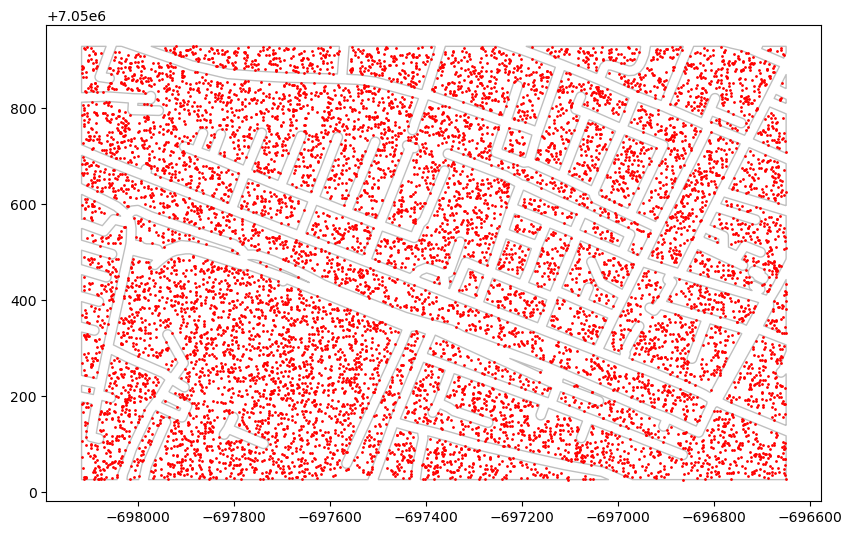

In [16]:
whitworth_poly = gpd.read_file("geojson_polygons/whitworth_road_buffers.geojson")

whitworth_points = points_uniform(whitworth_poly, 10000)

print("Generated points:", len(whitworth_points))

fig, ax = plt.subplots(1,1,figsize=(10,8))

whitworth_poly.plot(ax=ax, facecolor='none', edgecolor='black', alpha=0.25)
whitworth_points.plot(ax=ax, color='red', markersize=1)
#cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)


C:\Users\Paddy\AppData\Local\Temp\ipykernel_22120\3518473936.py:30: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  test_buffer_gdf = gpd.GeoDataFrame(geometry=test_join_buffer.boundary.explode())


<Axes: >

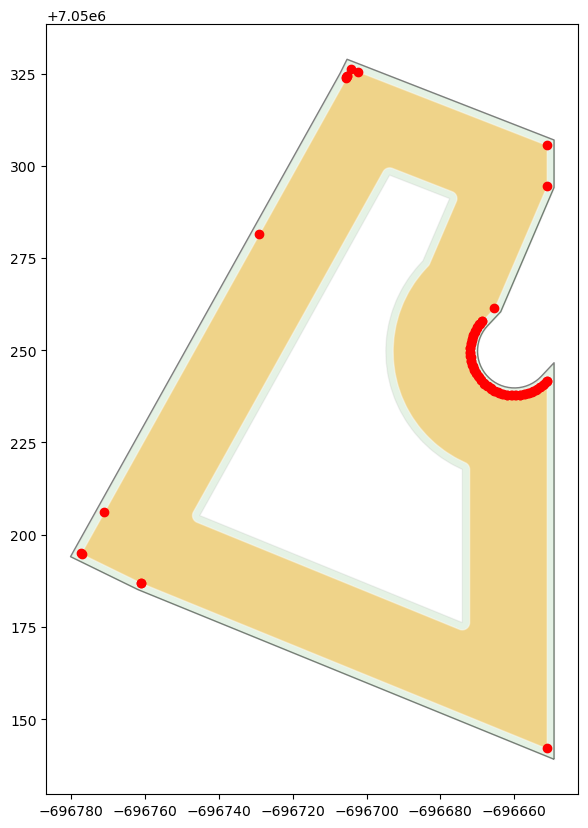

In [99]:
whitworth_poly = gpd.read_file("geojson_polygons/whitworth_road_buffers.geojson")

def point_on_line(line):
    p1 = line.coords[0]
    p2 = line.coords[-1]
    u = random.uniform(0,1)
    
    x1 = [(1-u) * x for x in p1]
    x2 = [u*x for x in p2]
    return Point(np.add(x1,x2))

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

def points_on_vertices(shape):
    vertices = segments(shape.boundary)
    return gpd.GeoDataFrame(pd.DataFrame([point_on_line(x) for x in vertices], columns=['geometry']),geometry='geometry')

def get_bounds_points(shape):
    return gpd.GeoDataFrame(pd.DataFrame([shapely.Point(x) for x in shape.boundary.coords], columns=['geometry']),geometry='geometry')

def get_bounds_points_linestring(shape):
    return gpd.GeoDataFrame(pd.DataFrame([shapely.Point(x) for x in shape.coords], columns=['geometry']),geometry='geometry')

test_poly = whitworth_poly.iloc[[2]]
test_buffer = test_poly.buffer(-25)
test_join = test_poly.symmetric_difference(test_buffer)
test_join_buffer = test_join.buffer(-2)

test_buffer_gdf = gpd.GeoDataFrame(geometry=test_join_buffer.boundary.explode())

fig, ax = plt.subplots(1,1,figsize=(15,10))

test_poly.plot(ax=ax, facecolor='none', edgecolor='grey')
#cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)
#test_buffer.plot(ax=ax, color='red', alpha=0.4)
test_join.plot(ax=ax, facecolor='green', edgecolor='grey', alpha=0.1)
test_join_buffer.plot(ax=ax, facecolor='orange', edgecolor='white', alpha=0.4)
get_bounds_points_linestring(test_buffer_gdf.iloc[0]['geometry']).plot(ax=ax, color='red')
